In [2]:
!pip install pdfplumber


In [3]:
!pip install ollama

In [4]:
import pandas as pd
import os
import pdfplumber
import ollama
import time
import json
import re
import matplotlib.pyplot as plt

# --- CONFIGURAÇÕES DO SEU AMBIENTE ---
# Caminho da pasta raiz
CAMINHO_BASE = r'C:\Iris\Mestrado_IDP\05_DEEP Learning e Processamento de Linguagem Natural\Trabalho final Deep Learning\Processos'

# Caminho onde estão os PDFs
#PASTA_PDFS = os.path.join(CAMINHO_BASE, 'Processos Filtrados')
#PASTA_PDFS = os.path.join(CAMINHO_BASE, 'Processos')
PASTA_PDFS = r'C:\Iris\Mestrado_IDP\05_DEEP Learning e Processamento de Linguagem Natural\Trabalho final Deep Learning\Processos'

# Caminho do arquivo CSV de entrada
ARQUIVO_CSV = os.path.join(CAMINHO_BASE, 'amostra_processos_final.csv')

# Caminho onde vamos salvar o resultado final
ARQUIVO_SAIDA = os.path.join(CAMINHO_BASE, 'resultado_sentimentos_final_v3.csv')

# Definição do Modelo Ollama
MODELO_LLM = "llama3:8b" 

print(f"📂 Diretório Base: {CAMINHO_BASE}")
print(f"🤖 Modelo Selecionado: {MODELO_LLM}")

📂 Diretório Base: C:\Iris\Mestrado_IDP\05_DEEP Learning e Processamento de Linguagem Natural\Trabalho final Deep Learning\Processos
🤖 Modelo Selecionado: llama3:8b


In [44]:

try:
    # 1. Carrega o CSV
    df = pd.read_csv(ARQUIVO_CSV)
   # df = pd.read_csv(ARQUIVO_CSV, sep=';')


    
    # 2. Renomeia as colunas
    df = df.rename(columns={
        'NUP_Formatado': 'N_Processo',
        'Target': 'Cat_Decisao',
        'Genero': 'Cat_Genero'
    })
    
    # 3. Remove coluna antiga se existir
    df = df.drop(columns=['Magistrado_Scraping'], errors='ignore')
    
    print(f"✅ Tabela carregada com sucesso! Total de processos: {len(df)}")
    display(df.head(3))
    
except FileNotFoundError:
    print("❌ ERRO: O arquivo CSV não foi encontrado. Verifique o caminho na Célula 1.")

✅ Tabela carregada com sucesso! Total de processos: 529


,N_Processo,Decisao,Cat_Decisao,Cat_Genero
0,0701876-06.2021.8.02.0058,Procedência,2,0
1,0706300-28.2020.8.02.0058,Improcedência,0,1
2,0700082-34.2021.8.02.0030,Improcedência,0,0


In [45]:
df.head(10)

,N_Processo,Decisao,Cat_Decisao,Cat_Genero
0,0701876-06.2021.8.02.0058,Procedência,2,0
1,0706300-28.2020.8.02.0058,Improcedência,0,1
2,0700082-34.2021.8.02.0030,Improcedência,0,0
3,0700802-55.2021.8.02.0012,Improcedência,0,1
4,0700226-42.2021.8.02.0051,Procedência em Parte,1,1
5,0713568-81.2018.8.02.0001,Procedência,2,0
6,0726130-20.2021.8.02.0001,Improcedência,0,0
7,0700313-55.2021.8.02.0032,Improcedência,0,1
8,0701104-52.2021.8.02.0055,Procedência,2,1
9,0706741-49.2021.8.02.0001,Procedência em Parte,1,0


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   N_Processo   529 non-null    object
 1   Decisao      529 non-null    object
 2   Cat_Decisao  529 non-null    int64 
 3   Cat_Genero   529 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 16.7+ KB


In [47]:
# ================= 1. LEITURA DE PDF =================
def extrair_texto_completo(nup):
    """Lê o arquivo PDF na pasta configurada."""
    nome_arquivo = f"{nup}.pdf"
    caminho_completo = os.path.join(PASTA_PDFS, nome_arquivo)
    
    # Estratégia de busca alternativa (caso o nome tenha caracteres especiais)
    if not os.path.exists(caminho_completo):
        nup_limpo = re.sub(r'[^0-9]', '', str(nup)) 
        caminho_alternativo = os.path.join(PASTA_PDFS, f"{nup_limpo}.pdf")
        if os.path.exists(caminho_alternativo):
            caminho_completo = caminho_alternativo
        else:
            return "" # Retorna vazio se não achar

    texto_extraido = ""
    try:
        with pdfplumber.open(caminho_completo) as pdf:
            for page in pdf.pages:
                texto_pagina = page.extract_text()
                if texto_pagina:
                    texto_extraido += texto_pagina + "\n"
        return texto_extraido
    except Exception as e:
        print(f"Erro ao ler PDF {nup}: {e}")
        return ""

# ================= 2. LIMPEZA DE TEXTO =================
def limpar_texto_juridico(texto):
    """Remove cabeçalhos e formatação inútil."""
    if not texto: return ""
    
    padroes_lixo = [
        r"PODER JUDICIARIO", r"DE ALAGOAS", r"Juízo de Direito", 
        r"assinado digitalmente", r"fls\.", r"__ PAGE"
    ]
    
    linhas = texto.split('\n')
    linhas_limpas = []
    
    for linha in linhas:
        # Pula linhas inúteis ou muito curtas
        if not any(re.search(p, linha, re.IGNORECASE) for p in padroes_lixo) and len(linha.strip()) > 5:
            linhas_limpas.append(linha)
            
    return "\n".join(linhas_limpas).replace('{','').replace('}','')

# ================= 3. CONSULTA À IA (OLLAMA) =================
def consultar_llm_sentimento(texto_decisao):
    """Envia o texto para o Llama 3.2 e analisa o tom."""
    
    texto_tratado = limpar_texto_juridico(texto_decisao)
    
    # Corte para economizar memória (Início + Fim da sentença)
    if len(texto_tratado) > 6000:
        texto_final = texto_tratado[:2000] + "\n...[CORTE]...\n" + texto_tratado[-4000:]
    else:
        texto_final = texto_tratado

    # O Prompt (Instrução para a IA)
    prompt_sistema = """
    Você é um linguista forense. Analise o TOM do juiz.
    
    CLASSIFICAÇÕES PERMITIDAS:
    1. RIGIDO (Duro, critica má-fé, sermão, termos como 'aventura jurídica')
    2. EMPATICO (Sensível, cita dignidade, protege vulnerável, lamenta danos)
    3. TECNICO (Frio, burocrático, apenas lei, 'copia e cola')
    
    NIVEL DE CONFIANÇA:
    - ALTA: Adjetivos claros.
    - MEDIA: Viés perceptível mas texto padrão.
    - BAIXA: Texto ambíguo ou genérico.

    Retorne APENAS JSON:
    {
        "classificacao": "RIGIDO" ou "EMPATICO" ou "TECNICO",
        "confianca": "ALTA" ou "MEDIA" ou "BAIXA",
        "justificativa": "resumo curto do motivo"
    }
    """
    
    try:
        resposta = ollama.chat(
            model=MODELO_LLM, 
            format='json',
            options={'temperature': 0.1}, 
            messages=[
                {'role': 'system', 'content': prompt_sistema},
                {'role': 'user', 'content': f"TEXTO:\n{texto_final}"} 
            ]
        )
        
        conteudo = resposta['message']['content']
        match = re.search(r'\{.*\}', conteudo, re.DOTALL)
        
        if match:
            dados = json.loads(match.group(0))
            return {
                "sentimento": dados.get("classificacao", "NEUTRO").upper(),
                "confianca": dados.get("confianca", "BAIXA").upper(),
                "tom": dados.get("justificativa", "Sem justificativa"),
                "trecho_chave": "Processado via Llama" 
            }
        else:
            return {"sentimento": "ERRO_FORMATO", "confianca": "N/A", "tom": "JSON Falhou", "trecho_chave": ""}

    except Exception as e:
        return {"sentimento": "ERRO_SISTEMA", "confianca": "N/A", "tom": str(e), "trecho_chave": ""}

print("✅ Funções carregadas na memória!")

✅ Funções carregadas na memória!


In [ ]:
# Configuração de salvamento
SALVAR_A_CADA = 10 
resultados_buffer = []
inicio_total = time.time()

print(f"🚀 Iniciando processamento de {len(df)} processos...")

for i, (index, row) in enumerate(df.iterrows()):
    nup = row['N_Processo']
    
    # Barra visual de progresso
    print(f"\r[{i+1}/{len(df)}] Processando {nup}...", end="") 
    
    texto = extrair_texto_completo(nup)
    
    if texto:
        analise = consultar_llm_sentimento(texto)
        resultados_buffer.append({
            "N_Processo": nup,
            "Sentimento_IA": analise.get('sentimento'),
            "Confianca_IA": analise.get('confianca'),
            "Tom_IA": analise.get('tom'),
            "Texto_Processado": True
        })
    else:
        # Caso não ache o PDF
        resultados_buffer.append({
            "N_Processo": nup,
            "Sentimento_IA": "ARQUIVO_ERRO",
            "Confianca_IA": "N/A",
            "Tom_IA": "PDF Vazio/Não achado",
            "Texto_Processado": False
        })
    
    # Salva checkpoint a cada 10 processos
    if (i + 1) % SALVAR_A_CADA == 0:
        pd.DataFrame(resultados_buffer).to_csv(ARQUIVO_SAIDA, index=False, sep=';', encoding='utf-8-sig')

# Salvamento Final
df_final_ia = pd.DataFrame(resultados_buffer)
df_final_ia.to_csv(ARQUIVO_SAIDA, index=False, sep=';', encoding='utf-8-sig')

tempo = (time.time() - inicio_total) / 60
print(f"\n\n✅ CONCLUÍDO! Tempo: {tempo:.2f} min.")
display(df_final_ia.head())

🚀 Iniciando processamento de 529 processos...
[3/529] Processando 0700082-34.2021.8.02.0030...

In [5]:
# 1. Carrega os DataFrames (para garantir)
df_origem = pd.read_csv(ARQUIVO_CSV)
df_origem = df_origem.rename(columns={'NUP_Formatado': 'N_Processo', 'Target': 'Cat_Decisao', 'Genero': 'Cat_Genero'})

df_ia = pd.read_csv(ARQUIVO_SAIDA, sep=';')

# 2. Faz o cruzamento (Merge)
df_completo = pd.merge(left=df_origem, right=df_ia, on='N_Processo', how='left')

# 3. Cria a coluna de Confiança Numérica

# 4. Salva o arquivo final "Ouro"
NOME_ARQUIVO_CONSOLIDADO = os.path.join(CAMINHO_BASE, 'base_completa_analisada.csv')
df_completo.to_csv(NOME_ARQUIVO_CONSOLIDADO, index=False, sep=';', encoding='utf-8-sig')

print(f"💾 Base consolidada salva em: {NOME_ARQUIVO_CONSOLIDADO}")
display(df_completo.head())

💾 Base consolidada salva em: C:\Iris\Mestrado_IDP\05_DEEP Learning e Processamento de Linguagem Natural\Trabalho final Deep Learning\Processos\base_completa_analisada.csv


,N_Processo,Decisao,Magistrado_Scraping,Cat_Decisao,Cat_Genero,Sentimento_IA,Confianca_IA,Tom_IA,Texto_Processado
0,0701876-06.2021.8.02.0058,Procedência,José Miranda Santos Junior,2,0,RIGIDO,ALTA,Sem justificativa,True
1,0706300-28.2020.8.02.0058,Improcedência,Luciana Josué Raposo Lima Dias,0,1,RIGIDO,BAIXA,Sem justificativa,True
2,0700082-34.2021.8.02.0030,Improcedência,Bruce Lee Simões Pimentel,0,0,RIGIDO,BAIXA,Sem justificativa,True
3,0700802-55.2021.8.02.0012,Improcedência,Natália Cerqueira de Castro,0,1,RIGIDO,BAIXA,Sem justificativa,True
4,0700226-42.2021.8.02.0051,Procedência em Parte,Larrissa Gabriella Lins Victor Lacerda,1,1,RIGIDO,BAIXA,"O tom do juiz é rigoroso e critica a má-fé, mo...",True


In [6]:
print("--- Tipos de Tom_IA encontrados ---")
print(df_completo['Tom_IA'].unique())

--- Tipos de Tom_IA encontrados ---
['Sem justificativa'
 'O tom do juiz é rigoroso e critica a má-fé, mostrando-se duro e firme na aplicação da lei. A linguagem utilizada é clara e objetiva, sem concessões ou sentimentalismo.'
 'O juiz demonstrou sensibilidade ao caso, citando a dignidade dos consumidores e o princípio da boa-fé. A linguagem utilizada é clara e objetiva, mostrando que o juiz está preocupado com a proteção do vulnerável e a justiça.'
 'O tom do juiz é rigoroso e critico, com uso de linguagem formal e técnica. A decisão é clara e objetiva, sem emoção ou sensibilidade.'
 'O despacho é genérico e não apresenta linguagem emotiva ou crítica, caracterizando-se por ser um texto burocrático.'
 'O juiz apresentou um tom rigoroso e critico, com uma linguagem formal e técnica. A sentença é clara e objetiva, sem emoções ou sentimentos. O tom é frio e burocrático, caracterizando-se como uma sentença técnica e jurídica.'
 'llama runner process no longer running: 1 CUDA error (status


--- Distribuição Percentual ---


Sentimento_IA,EMPATICO,ERRO_SISTEMA,RIGIDO,TECNICO
Cat_Genero,,,,
Feminino,12.8,0.9,78.9,7.3
Masculino,9.2,0.0,82.7,8.1


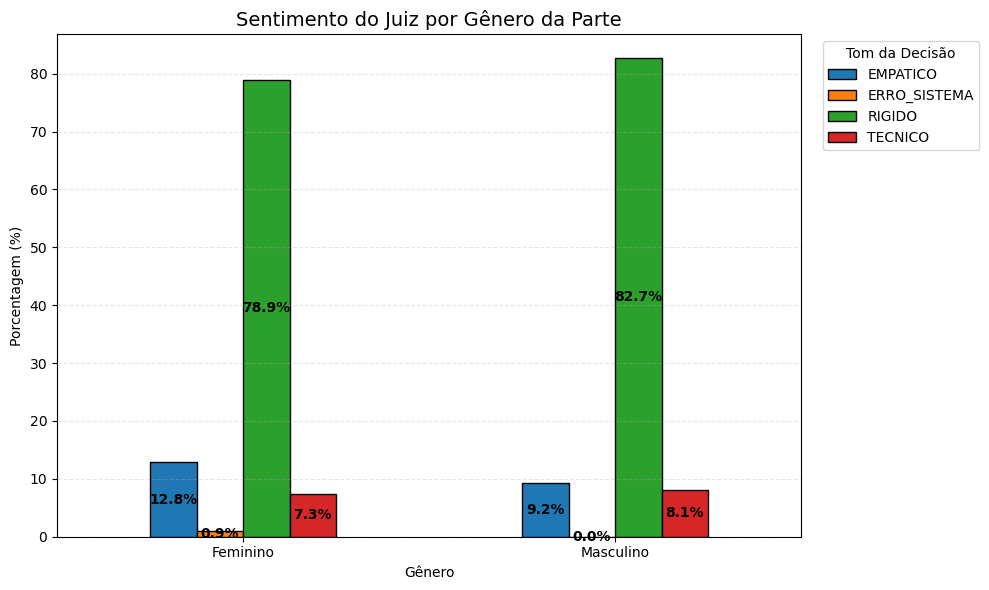

In [7]:
# Configuração visual
mapa_visual = {0: 'Masculino', 1: 'Feminino'}

# Cria a tabela cruzada com os nomes mapeados
tabela_pct = pd.crosstab(
    index=df_completo['Cat_Genero'].map(mapa_visual), 
    columns=df_completo['Sentimento_IA'],
    normalize='index' 
) * 100

print("\n--- Distribuição Percentual ---")
display(tabela_pct.round(1))

# Plota o gráfico
ax = tabela_pct.plot(kind='bar', figsize=(10, 6), edgecolor='black', rot=0)

plt.title('Sentimento do Juiz por Gênero da Parte', fontsize=14)
plt.ylabel('Porcentagem (%)')
plt.xlabel('Gênero')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(title='Tom da Decisão', bbox_to_anchor=(1.02, 1), loc='upper left')

# Adiciona os números nas barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', color='black', weight='bold')

plt.tight_layout()
plt.show()

✅ Dados carregados! Total de linhas: 531


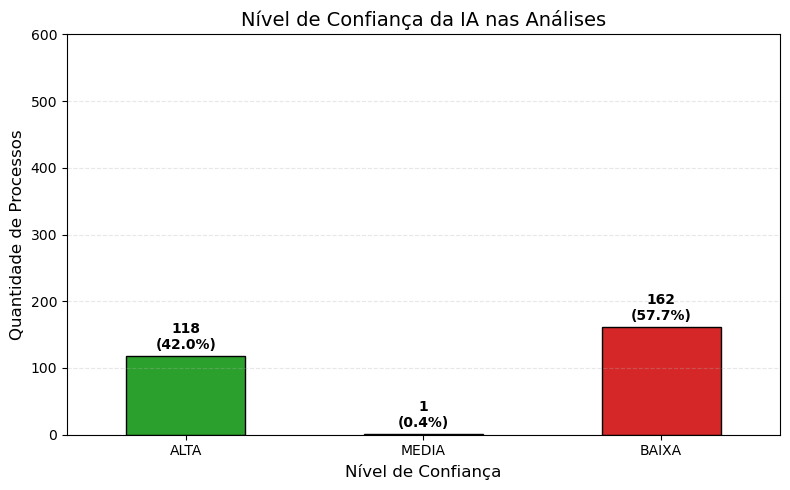

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- 1. Carregamento dos Dados ---
CAMINHO_BASE = r'C:\Iris\Mestrado_IDP\05_DEEP Learning e Processamento de Linguagem Natural\Trabalho final Deep Learning\Processos'
ARQUIVO_FINAL = os.path.join(CAMINHO_BASE, 'base_completa_analisada.csv')

try:
    df = pd.read_csv(ARQUIVO_FINAL, sep=';')
    print(f"✅ Dados carregados! Total de linhas: {len(df)}")
except FileNotFoundError:
    print("❌ Arquivo não encontrado.")
    # Cria um DF de exemplo caso o arquivo não exista, só para o gráfico funcionar
    df = pd.DataFrame({'Confianca_IA': ['ALTA']*498 + ['BAIXA']*2})

# --- 2. Preparação dos Dados ---
contagem = df['Confianca_IA'].value_counts()
porcentagem = df['Confianca_IA'].value_counts(normalize=True) * 100

# --- 3. Plotagem do Gráfico ---
plt.figure(figsize=(8, 5))

# Ordem das barras
ordem_desejada = [x for x in ['ALTA', 'MEDIA', 'BAIXA', 'N/A'] if x in contagem.index]
ax = contagem[ordem_desejada].plot(kind='bar', color=['#2ca02c', '#ff7f0e', '#d62728', '#7f7f7f'], edgecolor='black')

plt.title('Nível de Confiança da IA nas Análises', fontsize=14)
plt.xlabel('Nível de Confiança', fontsize=12)
plt.ylabel('Quantidade de Processos', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# --- AJUSTE SOLICITADO: Aumenta o teto do eixo Y para 600 ---
plt.ylim(0, 600) 

# Adiciona os rótulos de dados
for i, v in enumerate(contagem[ordem_desejada]):
    pct = porcentagem[ordem_desejada[i]]
    # O ajuste de posição (+ 10) ajuda o texto a não ficar colado na barra
    ax.text(i, v + 10, f"{v}\n({pct:.1f}%)", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [67]:
print(contagem.index)

Index([], dtype='float64', name='Confianca_IA')
